In [218]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from itertools import product
from sklearn.feature_selection import VarianceThreshold
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.cluster.hierarchy import linkage, fcluster
from scipy.spatial.distance import squareform

In [219]:
# 1. Load data
events = pd.read_csv('data/events.csv')
games_info = pd.read_csv('data/ginf.csv')

In [220]:
events

,id_odsp,id_event,sort_order,time,text,event_type,event_type2,side,event_team,opponent,player,player2,player_in,player_out,shot_place,shot_outcome,is_goal,location,bodypart,assist_method,situation,fast_break
0,UFot0hit/,UFot0hit1,1,2,Attempt missed. Mladen Petric (Hamburg) left f...,1,12.0,2,Hamburg SV,Borussia Dortmund,mladen petric,gokhan tore,NaN,NaN,6.0,2.0,0,9.0,2.0,1,1.0,0
1,UFot0hit/,UFot0hit2,2,4,"Corner, Borussia Dortmund. Conceded by Dennis...",2,NaN,1,Borussia Dortmund,Hamburg SV,dennis diekmeier,dennis diekmeier,NaN,NaN,NaN,NaN,0,NaN,NaN,0,NaN,0
2,UFot0hit/,UFot0hit3,3,4,"Corner, Borussia Dortmund. Conceded by Heiko ...",2,NaN,1,Borussia Dortmund,Hamburg SV,heiko westermann,heiko westermann,NaN,NaN,NaN,NaN,0,NaN,NaN,0,NaN,0
3,UFot0hit/,UFot0hit4,4,7,Foul by Sven Bender (Borussia Dortmund).,3,NaN,1,Borussia Dortmund,Hamburg SV,sven bender,NaN,NaN,NaN,NaN,NaN,0,NaN,NaN,0,NaN,0
4,UFot0hit/,UFot0hit5,5,7,Gokhan Tore (Hamburg) wins a free kick in the ...,8,NaN,2,Hamburg SV,Borussia Dortmund,gokhan tore,NaN,NaN,NaN,NaN,NaN,0,2.0,NaN,0,NaN,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
941004,z5L2OT5E/,z5L2OT5E123,123,92,Lucas Torreira (Sampdoria) wins a free kick in...,8,NaN,2,Sampdoria,Atalanta,lucas torreira,NaN,NaN,NaN,NaN,NaN,0,2.0,NaN,0,NaN,0
941005,z5L2OT5E/,z5L2OT5E124,124,93,"Corner, Sampdoria. Conceded by Andrea Masiello.",2,NaN,2,Sampdoria,Atalanta,NaN,NaN,NaN,NaN,NaN,NaN,0,NaN,NaN,0,NaN,0
941006,z5L2OT5E/,z5L2OT5E125,125,93,Attempt missed. Fabio Quagliarella (Sampdoria)...,1,12.0,2,Sampdoria,Atalanta,fabio quagliarella,lucas torreira,NaN,NaN,8.0,2.0,0,9.0,1.0,1,3.0,0
941007,z5L2OT5E/,z5L2OT5E126,126,94,Alberto Grassi (Atalanta) wins a free kick on ...,8,NaN,1,Atalanta,Sampdoria,alberto grassi,NaN,NaN,NaN,NaN,NaN,0,4.0,NaN,0,NaN,0


In [221]:
games_info

,id_odsp,link_odsp,adv_stats,date,league,season,country,ht,at,fthg,ftag,odd_h,odd_d,odd_a,odd_over,odd_under,odd_bts,odd_bts_n
0,UFot0hit/,/soccer/germany/bundesliga-2011-2012/dortmund-...,True,2011-08-05,D1,2012,germany,Borussia Dortmund,Hamburg SV,3,1,1.56,4.41,7.42,NaN,NaN,NaN,NaN
1,Aw5DflLH/,/soccer/germany/bundesliga-2011-2012/augsburg-...,True,2011-08-06,D1,2012,germany,FC Augsburg,SC Freiburg,2,2,2.36,3.60,3.40,NaN,NaN,NaN,NaN
2,bkjpaC6n/,/soccer/germany/bundesliga-2011-2012/werder-br...,True,2011-08-06,D1,2012,germany,Werder Bremen,Kaiserslautern,2,0,1.83,4.20,4.80,NaN,NaN,NaN,NaN
3,CzPV312a/,/soccer/france/ligue-1-2011-2012/paris-sg-lori...,True,2011-08-06,F1,2012,france,Paris Saint-Germain,Lorient,0,1,1.55,4.50,9.40,NaN,NaN,NaN,NaN
4,GUOdmtII/,/soccer/france/ligue-1-2011-2012/caen-valencie...,True,2011-08-06,F1,2012,france,Caen,Valenciennes,1,0,2.50,3.40,3.45,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10107,xAkY8l6R/,/soccer/italy/serie-a/genoa-crotone-xAkY8l6R/,True,2017-01-22,I1,2017,italy,Genoa,Crotone,2,2,1.97,4.35,8.00,1.95,2.03,2.03,1.86
10108,xSU9scI9/,/soccer/england/premier-league/chelsea-hull-ci...,True,2017-01-22,E0,2017,england,Chelsea,Hull,2,0,1.19,8.50,20.00,1.54,2.68,2.40,1.66
10109,xY7uZwOI/,/soccer/france/ligue-1/monaco-lorient-xY7uZwOI/,True,2017-01-22,F1,2017,france,AS Monaco,Lorient,4,0,1.32,6.24,11.50,1.53,3.08,1.80,2.25
10110,YyeGxMX8/,/soccer/spain/laliga/betis-gijon-YyeGxMX8/,True,2017-01-22,SP1,2017,spain,Real Betis,Sporting Gijon,0,0,1.74,4.07,5.90,2.20,1.89,2.05,1.86


In [222]:
# 2. Filter relevant columns
#    Incorporate shot_place, shot_outcome, side, etc.
relevant_columns = [
    'event_team',
    'event_type',
    'event_type2',
    'location',
    'assist_method',
    'situation',
    'bodypart',
    'shot_place',
    'shot_outcome'
]
events = events[relevant_columns]
events

,event_team,event_type,event_type2,location,assist_method,situation,bodypart,shot_place,shot_outcome
0,Hamburg SV,1,12.0,9.0,1,1.0,2.0,6.0,2.0
1,Borussia Dortmund,2,NaN,NaN,0,NaN,NaN,NaN,NaN
2,Borussia Dortmund,2,NaN,NaN,0,NaN,NaN,NaN,NaN
3,Borussia Dortmund,3,NaN,NaN,0,NaN,NaN,NaN,NaN
4,Hamburg SV,8,NaN,2.0,0,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...
941004,Sampdoria,8,NaN,2.0,0,NaN,NaN,NaN,NaN
941005,Sampdoria,2,NaN,NaN,0,NaN,NaN,NaN,NaN
941006,Sampdoria,1,12.0,9.0,1,3.0,1.0,8.0,2.0
941007,Atalanta,8,NaN,4.0,0,NaN,NaN,NaN,NaN


In [223]:
# Drop rows with missing critical values
critical_columns = ['event_team', 'event_type']
events = events.dropna(subset=critical_columns)
events

,event_team,event_type,event_type2,location,assist_method,situation,bodypart,shot_place,shot_outcome
0,Hamburg SV,1,12.0,9.0,1,1.0,2.0,6.0,2.0
1,Borussia Dortmund,2,NaN,NaN,0,NaN,NaN,NaN,NaN
2,Borussia Dortmund,2,NaN,NaN,0,NaN,NaN,NaN,NaN
3,Borussia Dortmund,3,NaN,NaN,0,NaN,NaN,NaN,NaN
4,Hamburg SV,8,NaN,2.0,0,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...
941004,Sampdoria,8,NaN,2.0,0,NaN,NaN,NaN,NaN
941005,Sampdoria,2,NaN,NaN,0,NaN,NaN,NaN,NaN
941006,Sampdoria,1,12.0,9.0,1,3.0,1.0,8.0,2.0
941007,Atalanta,8,NaN,4.0,0,NaN,NaN,NaN,NaN


In [224]:
# One-hot encode categorical columns
categorical_columns = [
    'event_type',
    'event_type2',
    'location',
    'assist_method',
    'situation',
    'bodypart',
    'shot_place',
    'shot_outcome'
]
encoder = OneHotEncoder(sparse_output=False)
encoded = encoder.fit_transform(events[categorical_columns])

In [225]:
# Create a DataFrame with the encoded features
encoded_feature_names = encoder.get_feature_names_out(categorical_columns)
encoded_features = pd.DataFrame(encoded, columns=encoded_feature_names)
encoded_features

,event_type_1,event_type_2,event_type_3,event_type_4,event_type_5,event_type_6,event_type_7,event_type_8,event_type_9,event_type_10,event_type_11,event_type2_12.0,event_type2_13.0,event_type2_14.0,event_type2_15.0,event_type2_nan,location_1.0,location_2.0,location_3.0,location_4.0,location_5.0,location_6.0,location_7.0,location_8.0,location_9.0,location_10.0,location_11.0,location_12.0,location_13.0,location_14.0,location_15.0,location_16.0,location_17.0,location_18.0,location_19.0,location_nan,assist_method_0,assist_method_1,assist_method_2,assist_method_3,assist_method_4,situation_1.0,situation_2.0,situation_3.0,situation_4.0,situation_nan,bodypart_1.0,bodypart_2.0,bodypart_3.0,bodypart_nan,shot_place_1.0,shot_place_2.0,shot_place_3.0,shot_place_4.0,shot_place_5.0,shot_place_6.0,shot_place_7.0,shot_place_8.0,shot_place_9.0,shot_place_10.0,shot_place_11.0,shot_place_12.0,shot_place_13.0,shot_place_nan,shot_outcome_1.0,shot_outcome_2.0,shot_outcome_3.0,shot_outcome_4.0,shot_outcome_nan
0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
1,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0
2,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0
3,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
941004,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0
941005,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0
941006,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
941007,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0


In [226]:
# Combine encoded features with the team column
data_encoded = pd.concat([events['event_team'].reset_index(drop=True), encoded_features], axis=1)
data_encoded

,event_team,event_type_1,event_type_2,event_type_3,event_type_4,event_type_5,event_type_6,event_type_7,event_type_8,event_type_9,event_type_10,event_type_11,event_type2_12.0,event_type2_13.0,event_type2_14.0,event_type2_15.0,event_type2_nan,location_1.0,location_2.0,location_3.0,location_4.0,location_5.0,location_6.0,location_7.0,location_8.0,location_9.0,location_10.0,location_11.0,location_12.0,location_13.0,location_14.0,location_15.0,location_16.0,location_17.0,location_18.0,location_19.0,location_nan,assist_method_0,assist_method_1,assist_method_2,assist_method_3,assist_method_4,situation_1.0,situation_2.0,situation_3.0,situation_4.0,situation_nan,bodypart_1.0,bodypart_2.0,bodypart_3.0,bodypart_nan,shot_place_1.0,shot_place_2.0,shot_place_3.0,shot_place_4.0,shot_place_5.0,shot_place_6.0,shot_place_7.0,shot_place_8.0,shot_place_9.0,shot_place_10.0,shot_place_11.0,shot_place_12.0,shot_place_13.0,shot_place_nan,shot_outcome_1.0,shot_outcome_2.0,shot_outcome_3.0,shot_outcome_4.0,shot_outcome_nan
0,Hamburg SV,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
1,Borussia Dortmund,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0
2,Borussia Dortmund,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0
3,Borussia Dortmund,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0
4,Hamburg SV,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
941004,Sampdoria,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0
941005,Sampdoria,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0
941006,Sampdoria,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
941007,Atalanta,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0


In [227]:
# Group by team
team_aggregated = data_encoded.groupby('event_team').sum().reset_index()
team_aggregated

,event_team,event_type_1,event_type_2,event_type_3,event_type_4,event_type_5,event_type_6,event_type_7,event_type_8,event_type_9,event_type_10,event_type_11,event_type2_12.0,event_type2_13.0,event_type2_14.0,event_type2_15.0,event_type2_nan,location_1.0,location_2.0,location_3.0,location_4.0,location_5.0,location_6.0,location_7.0,location_8.0,location_9.0,location_10.0,location_11.0,location_12.0,location_13.0,location_14.0,location_15.0,location_16.0,location_17.0,location_18.0,location_19.0,location_nan,assist_method_0,assist_method_1,assist_method_2,assist_method_3,assist_method_4,situation_1.0,situation_2.0,situation_3.0,situation_4.0,situation_nan,bodypart_1.0,bodypart_2.0,bodypart_3.0,bodypart_nan,shot_place_1.0,shot_place_2.0,shot_place_3.0,shot_place_4.0,shot_place_5.0,shot_place_6.0,shot_place_7.0,shot_place_8.0,shot_place_9.0,shot_place_10.0,shot_place_11.0,shot_place_12.0,shot_place_13.0,shot_place_nan,shot_outcome_1.0,shot_outcome_2.0,shot_outcome_3.0,shot_outcome_4.0,shot_outcome_nan
0,AC Ajaccio,1106.0,449.0,1593.0,238.0,0.0,12.0,307.0,1534.0,365.0,96.0,15.0,762.0,365.0,17.0,4.0,4567.0,285.0,850.0,336.0,212.0,187.0,9.0,9.0,10.0,71.0,13.0,92.0,12.0,27.0,15.0,457.0,24.0,20.0,3.0,8.0,3075.0,4953.0,490.0,198.0,43.0,31.0,913.0,86.0,74.0,33.0,4609.0,566.0,374.0,166.0,4609.0,19.0,245.0,86.0,80.0,126.0,89.0,21.0,136.0,122.0,90.0,25.0,28.0,30.0,4618.0,370.0,466.0,245.0,21.0,4613.0
1,AC Milan,3065.0,1225.0,2677.0,499.0,3.0,18.0,593.0,2840.0,543.0,128.0,42.0,2200.0,543.0,39.0,11.0,8840.0,673.0,1484.0,784.0,344.0,339.0,10.0,28.0,35.0,215.0,34.0,256.0,29.0,93.0,51.0,1465.0,23.0,19.0,1.0,22.0,5728.0,9433.0,1556.0,477.0,61.0,106.0,2615.0,144.0,219.0,87.0,8568.0,1936.0,788.0,341.0,8568.0,69.0,782.0,267.0,255.0,308.0,219.0,48.0,357.0,305.0,224.0,63.0,68.0,72.0,8596.0,1030.0,1196.0,782.0,48.0,8577.0
2,AJ Auxerre,446.0,178.0,558.0,89.0,0.0,3.0,104.0,469.0,94.0,35.0,8.0,302.0,94.0,5.0,0.0,1583.0,108.0,237.0,123.0,70.0,54.0,6.0,4.0,4.0,48.0,10.0,33.0,10.0,18.0,1.0,173.0,5.0,8.0,1.0,2.0,1069.0,1682.0,174.0,92.0,16.0,20.0,364.0,18.0,41.0,23.0,1538.0,199.0,178.0,69.0,1538.0,6.0,96.0,28.0,39.0,56.0,36.0,6.0,48.0,47.0,48.0,10.0,8.0,16.0,1540.0,156.0,188.0,96.0,6.0,1538.0
3,AS Monaco,1665.0,727.0,1666.0,243.0,0.0,8.0,385.0,1736.0,285.0,106.0,29.0,1219.0,285.0,11.0,7.0,5328.0,407.0,848.0,558.0,221.0,260.0,8.0,19.0,16.0,131.0,32.0,128.0,44.0,56.0,26.0,607.0,11.0,9.0,2.0,18.0,3449.0,5631.0,754.0,363.0,49.0,53.0,1387.0,86.0,142.0,50.0,5185.0,797.0,574.0,294.0,5185.0,34.0,383.0,143.0,154.0,208.0,144.0,25.0,172.0,187.0,78.0,38.0,41.0,41.0,5202.0,622.0,630.0,383.0,25.0,5190.0
4,AS Nancy Lorraine,1058.0,356.0,1260.0,160.0,0.0,7.0,232.0,1174.0,254.0,67.0,12.0,791.0,254.0,8.0,1.0,3526.0,239.0,618.0,261.0,172.0,145.0,7.0,11.0,4.0,85.0,15.0,82.0,14.0,28.0,10.0,502.0,17.0,16.0,2.0,4.0,2348.0,3789.0,523.0,193.0,42.0,33.0,874.0,69.0,86.0,29.0,3522.0,651.0,239.0,168.0,3522.0,34.0,197.0,87.0,76.0,110.0,94.0,18.0,133.0,135.0,82.0,27.0,31.0,29.0,3527.0,347.0,495.0,197.0,18.0,3523.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
137,Villarreal,1849.0,798.0,2045.0,392.0,1.0,5.0,480.0,2085.0,465.0,104.0,24.0,1356.0,465.0,16.0,5.0,6406.0,476.0,1150.0,512.0,235.0,224.0,11.0,35.0,26.0,164.0,34.0,191.0,46.0,64.0,24.0,709.0,9.0,10.0,3.0,11.0,4314.0,6892.0,924.0,295.0,43.0,94.0,1578.0,83.0,146.0,42.0,6399.0,937.0,671.0,241.0,6399.0,61.0,424.0,161.0,151.0,244.0,80.0,29.0,205.0,221.0,118.0,45.0,45.0,50.0,6414.0,671.0,721.0,424.0,29.0,6403.0
138,Watford,678.0,250.0,725.0,129.0,1.0,4.0,164.0,639.0,82.0,16.0,6.0,465.0,82.0,6.0,3.0,2138.0,143.0,328.0,205.0,92.0,76.0,1.0,14.0,6.0,53.0,9.0,49.0,9.0,14.0,9.0,296.0,1.0,8.0,0.0,4.0,1377.0,2229.0,301.0,117.0,42.0,5.0,574.0,46.0,46.0,12.0,2016.0,432.0,149.0,97.0,2016.0,9.0,189.0,45.0,44.0,75.0,70.

In [228]:
# Print columns names
team_aggregated.columns

Index(['event_team', 'event_type_1', 'event_type_2', 'event_type_3',
       'event_type_4', 'event_type_5', 'event_type_6', 'event_type_7',
       'event_type_8', 'event_type_9', 'event_type_10', 'event_type_11',
       'event_type2_12.0', 'event_type2_13.0', 'event_type2_14.0',
       'event_type2_15.0', 'event_type2_nan', 'location_1.0', 'location_2.0',
       'location_3.0', 'location_4.0', 'location_5.0', 'location_6.0',
       'location_7.0', 'location_8.0', 'location_9.0', 'location_10.0',
       'location_11.0', 'location_12.0', 'location_13.0', 'location_14.0',
       'location_15.0', 'location_16.0', 'location_17.0', 'location_18.0',
       'location_19.0', 'location_nan', 'assist_method_0', 'assist_method_1',
       'assist_method_2', 'assist_method_3', 'assist_method_4',
       'situation_1.0', 'situation_2.0', 'situation_3.0', 'situation_4.0',
       'situation_nan', 'bodypart_1.0', 'bodypart_2.0', 'bodypart_3.0',
       'bodypart_nan', 'shot_place_1.0', 'shot_place_2.0', '

In [229]:
# 8. Optionally drop "Not recorded" if it exists in new columns 
#    (e.g., if there's a shot_place_nan or shot_outcome_nan or location_19.0)
columns_to_drop = [
    col for col in team_aggregated.columns 
    if any(substr in col for substr in ['nan', 'Not recorded']) or col.endswith('19.0') 
]
team_aggregated.drop(columns=columns_to_drop, errors='ignore', inplace=True)

In [230]:
team_aggregated.columns

Index(['event_team', 'event_type_1', 'event_type_2', 'event_type_3',
       'event_type_4', 'event_type_5', 'event_type_6', 'event_type_7',
       'event_type_8', 'event_type_9', 'event_type_10', 'event_type_11',
       'event_type2_12.0', 'event_type2_13.0', 'event_type2_14.0',
       'event_type2_15.0', 'location_1.0', 'location_2.0', 'location_3.0',
       'location_4.0', 'location_5.0', 'location_6.0', 'location_7.0',
       'location_8.0', 'location_9.0', 'location_10.0', 'location_11.0',
       'location_12.0', 'location_13.0', 'location_14.0', 'location_15.0',
       'location_16.0', 'location_17.0', 'location_18.0', 'assist_method_0',
       'assist_method_1', 'assist_method_2', 'assist_method_3',
       'assist_method_4', 'situation_1.0', 'situation_2.0', 'situation_3.0',
       'situation_4.0', 'bodypart_1.0', 'bodypart_2.0', 'bodypart_3.0',
       'shot_place_1.0', 'shot_place_2.0', 'shot_place_3.0', 'shot_place_4.0',
       'shot_place_5.0', 'shot_place_6.0', 'shot_place_7.

In [231]:
team_aggregated

,event_team,event_type_1,event_type_2,event_type_3,event_type_4,event_type_5,event_type_6,event_type_7,event_type_8,event_type_9,event_type_10,event_type_11,event_type2_12.0,event_type2_13.0,event_type2_14.0,event_type2_15.0,location_1.0,location_2.0,location_3.0,location_4.0,location_5.0,location_6.0,location_7.0,location_8.0,location_9.0,location_10.0,location_11.0,location_12.0,location_13.0,location_14.0,location_15.0,location_16.0,location_17.0,location_18.0,assist_method_0,assist_method_1,assist_method_2,assist_method_3,assist_method_4,situation_1.0,situation_2.0,situation_3.0,situation_4.0,bodypart_1.0,bodypart_2.0,bodypart_3.0,shot_place_1.0,shot_place_2.0,shot_place_3.0,shot_place_4.0,shot_place_5.0,shot_place_6.0,shot_place_7.0,shot_place_8.0,shot_place_9.0,shot_place_10.0,shot_place_11.0,shot_place_12.0,shot_place_13.0,shot_outcome_1.0,shot_outcome_2.0,shot_outcome_3.0,shot_outcome_4.0
0,AC Ajaccio,1106.0,449.0,1593.0,238.0,0.0,12.0,307.0,1534.0,365.0,96.0,15.0,762.0,365.0,17.0,4.0,285.0,850.0,336.0,212.0,187.0,9.0,9.0,10.0,71.0,13.0,92.0,12.0,27.0,15.0,457.0,24.0,20.0,3.0,4953.0,490.0,198.0,43.0,31.0,913.0,86.0,74.0,33.0,566.0,374.0,166.0,19.0,245.0,86.0,80.0,126.0,89.0,21.0,136.0,122.0,90.0,25.0,28.0,30.0,370.0,466.0,245.0,21.0
1,AC Milan,3065.0,1225.0,2677.0,499.0,3.0,18.0,593.0,2840.0,543.0,128.0,42.0,2200.0,543.0,39.0,11.0,673.0,1484.0,784.0,344.0,339.0,10.0,28.0,35.0,215.0,34.0,256.0,29.0,93.0,51.0,1465.0,23.0,19.0,1.0,9433.0,1556.0,477.0,61.0,106.0,2615.0,144.0,219.0,87.0,1936.0,788.0,341.0,69.0,782.0,267.0,255.0,308.0,219.0,48.0,357.0,305.0,224.0,63.0,68.0,72.0,1030.0,1196.0,782.0,48.0
2,AJ Auxerre,446.0,178.0,558.0,89.0,0.0,3.0,104.0,469.0,94.0,35.0,8.0,302.0,94.0,5.0,0.0,108.0,237.0,123.0,70.0,54.0,6.0,4.0,4.0,48.0,10.0,33.0,10.0,18.0,1.0,173.0,5.0,8.0,1.0,1682.0,174.0,92.0,16.0,20.0,364.0,18.0,41.0,23.0,199.0,178.0,69.0,6.0,96.0,28.0,39.0,56.0,36.0,6.0,48.0,47.0,48.0,10.0,8.0,16.0,156.0,188.0,96.0,6.0
3,AS Monaco,1665.0,727.0,1666.0,243.0,0.0,8.0,385.0,1736.0,285.0,106.0,29.0,1219.0,285.0,11.0,7.0,407.0,848.0,558.0,221.0,260.0,8.0,19.0,16.0,131.0,32.0,128.0,44.0,56.0,26.0,607.0,11.0,9.0,2.0,5631.0,754.0,363.0,49.0,53.0,1387.0,86.0,142.0,50.0,797.0,574.0,294.0,34.0,383.0,143.0,154.0,208.0,144.0,25.0,172.0,187.0,78.0,38.0,41.0,41.0,622.0,630.0,383.0,25.0
4,AS Nancy Lorraine,1058.0,356.0,1260.0,160.0,0.0,7.0,232.0,1174.0,254.0,67.0,12.0,791.0,254.0,8.0,1.0,239.0,618.0,261.0,172.0,145.0,7.0,11.0,4.0,85.0,15.0,82.0,14.0,28.0,10.0,502.0,17.0,16.0,2.0,3789.0,523.0,193.0,42.0,33.0,874.0,69.0,86.0,29.0,651.0,239.0,168.0,34.0,197.0,87.0,76.0,110.0,94.0,18.0,133.0,135.0,82.0,27.0,31.0,29.0,347.0,495.0,197.0,18.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
137,Villarreal,1849.0,798.0,2045.0,392.0,1.0,5.0,480.0,2085.0,465.0,104.0,24.0,1356.0,465.0,16.0,5.0,476.0,1150.0,512.0,235.0,224.0,11.0,35.0,26.0,164.0,34.0,191.0,46.0,64.0,24.0,709.0,9.0,10.0,3.0,6892.0,924.0,295.0,43.0,94.0,1578.0,83.0,146.0,42.0,937.0,671.0,241.0,61.0,424.0,161.0,151.0,244.0,80.0,29.0,205.0,221.0,118.0,45.0,45.0,50.0,671.0,721.0,424.0,29.0
138,Watford,678.0,250.0,725.0,129.0,1.0,4.0,164.0,639.0,82.0,16.0,6.0,465.0,82.0,6.0,3.0,143.0,328.0,205.0,92.0,76.0,1.0,14.0,6.0,53.0,9.0,49.0,9.0,14.0,9.0,296.0,1.0,8.0,0.0,2229.0,301.0,117.0,42.0,5.0,574.0,46.0,46.0,12.0,432.0,149.0,97.0,9.0,189.0,45.0,44.0,75.0,70.0,9.0,81.0,65.0,31.0,19.0,15.0,23.0,218.0,261.0,189.0,9.0
139,Werder Bremen,2318.0,860.0,2645.0,375.0,0.0,10.0,490.0,2714.0,419.0,110.0,34.0,1644.0,419.0,20.0,6.0,529.0,1540.0,726.0,296.0,349.0,24.0,26.0,31.0,184.0,50.0,184.0,42.0,70.0,27.0,885.0,34.0,15.0,3.0,8331.0,1082.0,415.0,108.0,39.0,1912.0,149.0,208.0,49.0,1302.0,623.0,393.0,60.0,550.0,175.0,204.0,251.0,132.0,38.0,301.0,229.0,162.0,51.0,67.0,80.0,804.0,921.0,550.0,38.0
140,West B

In [232]:
# Count games played for each team
# Combine home and away counts
games_played = games_info['ht'].value_counts() + games_info['at'].value_counts()
team_aggregated['games_played'] = team_aggregated['event_team'].map(games_played).fillna(1)  # Avoid division by zero

In [233]:
# Normalize event-related columns by games played
columns_to_normalize = [
    col for col in team_aggregated.columns 
    if col not in ['event_team', 'games_played']
]
for col in columns_to_normalize:
    team_aggregated[col] = team_aggregated[col] / team_aggregated['games_played']

In [234]:
pd.set_option('display.max_columns', None)  # Show all columns
pd.set_option('display.expand_frame_repr', False)  # Disable wrapping to new line
team_aggregated

,event_team,event_type_1,event_type_2,event_type_3,event_type_4,event_type_5,event_type_6,event_type_7,event_type_8,event_type_9,event_type_10,event_type_11,event_type2_12.0,event_type2_13.0,event_type2_14.0,event_type2_15.0,location_1.0,location_2.0,location_3.0,location_4.0,location_5.0,location_6.0,location_7.0,location_8.0,location_9.0,location_10.0,location_11.0,location_12.0,location_13.0,location_14.0,location_15.0,location_16.0,location_17.0,location_18.0,assist_method_0,assist_method_1,assist_method_2,assist_method_3,assist_method_4,situation_1.0,situation_2.0,situation_3.0,situation_4.0,bodypart_1.0,bodypart_2.0,bodypart_3.0,shot_place_1.0,shot_place_2.0,shot_place_3.0,shot_place_4.0,shot_place_5.0,shot_place_6.0,shot_place_7.0,shot_place_8.0,shot_place_9.0,shot_place_10.0,shot_place_11.0,shot_place_12.0,shot_place_13.0,shot_outcome_1.0,shot_outcome_2.0,shot_outcome_3.0,shot_outcome_4.0,games_played
0,AC Ajaccio,9.701754,3.938596,13.973684,2.087719,0.000000,0.105263,2.692982,13.456140,3.201754,0.842105,0.131579,6.684211,3.201754,0.149123,0.035088,2.500000,7.456140,2.947368,1.859649,1.640351,0.078947,0.078947,0.087719,0.622807,0.114035,0.807018,0.105263,0.236842,0.131579,4.008772,0.210526,0.175439,0.026316,43.447368,4.298246,1.736842,0.377193,0.271930,8.008772,0.754386,0.649123,0.289474,4.964912,3.280702,1.456140,0.166667,2.149123,0.754386,0.701754,1.105263,0.780702,0.184211,1.192982,1.070175,0.789474,0.219298,0.245614,0.263158,3.245614,4.087719,2.149123,0.184211,114.0
1,AC Milan,14.595238,5.833333,12.747619,2.376190,0.014286,0.085714,2.823810,13.523810,2.585714,0.609524,0.200000,10.476190,2.585714,0.185714,0.052381,3.204762,7.066667,3.733333,1.638095,1.614286,0.047619,0.133333,0.166667,1.023810,0.161905,1.219048,0.138095,0.442857,0.242857,6.976190,0.109524,0.090476,0.004762,44.919048,7.409524,2.271429,0.290476,0.504762,12.452381,0.685714,1.042857,0.414286,9.219048,3.752381,1.623810,0.328571,3.723810,1.271429,1.214286,1.466667,1.042857,0.228571,1.700000,1.452381,1.066667,0.300000,0.323810,0.342857,4.904762,5.695238,3.723810,0.228571,210.0
2,AJ Auxerre,11.736842,4.684211,14.684211,2.342105,0.000000,0.078947,2.736842,12.342105,2.473684,0.921053,0.210526,7.947368,2.473684,0.131579,0.000000,2.842105,6.236842,3.236842,1.842105,1.421053,0.157895,0.105263,0.105263,1.263158,0.263158,0.868421,0.263158,0.473684,0.026316,4.552632,0.131579,0.210526,0.026316,44.263158,4.578947,2.421053,0.421053,0.526316,9.578947,0.473684,1.078947,0.605263,5.236842,4.684211,1.815789,0.157895,2.526316,0.736842,1.026316,1.473684,0.947368,0.157895,1.263158,1.236842,1.263158,0.263158,0.210526,0.421053,4.105263,4.947368,2.526316,0.157895,38.0
3,AS Monaco,12.333333,5.385185,12.340741,1.800000,0.000000,0.059259,2.851852,12.859259,2.111111,0.785185,0.214815,9.029630,2.111111,0.081481,0.051852,3.014815,6.281481,4.133333,1.637037,1.925926,0.059259,0.140741,0.118519,0.970370,0.237037,0.948148,0.325926,0.414815,0.192593,4.496296,0.081481,0.066667,0.014815,41.711111,5.585185,2.688889,0.362963,0.392593,10.274074,0.637037,1.051852,0.370370,5.903704,4.251852,2.177778,0.251852,2.837037,1.059259,1.140741,1.540741,1.066667,0.185185,1.274074,1.385185,0.577778,0.281481,0.303704,0.303704,4.607407,4.666667,2.837037,0.185185,135.0
4,AS Nancy Lorraine,11.020833,3.708333,13.125000,1.666667,0.000000,0.072917,2.416667,12.229167,2.645833,0.697917,0.125000,8.239583,2.645833,0.083333,0.010417,2.489583,6.437500,2.718750,1.791667,1.510417,0.072917,0.114583,0.041667,0.885417,0.156250,0.854167,0.145833,0.291667,0.104167,5.229167,0.177083,0.166667,0.020833,39.468750,5.447917,2.010417,0.437500,0.343750,9.104167,0.718750,0.895833,0.302083,6.781250,2.489583,1.750000,0.354167,2.052083,0.906250,0.791667,1.145833,0.979167,0.187500,1.385417,1.406250,0.854167,0.281250,0.322917,0.302083,3.614583,5.156250,2.052083,0.187500,96.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,

In [235]:
# 11. Create additional aggregate statistics / ratios
#     Example: total attempts, total fouls, total red cards, etc.

# Identify relevant sets of columns 
event_type_cols       = [c for c in columns_to_normalize if c.startswith('event_type_')]
shot_outcome_cols     = [c for c in columns_to_normalize if c.startswith('shot_outcome_')]
shot_place_cols       = [c for c in columns_to_normalize if c.startswith('shot_place_')]
card_cols             = [c for c in event_type_cols if any(x in c for x in ['event_type_4', 'event_type_5', 'event_type_6'])]
foul_cols             = [c for c in event_type_cols if 'event_type_3' in c]

In [236]:
card_cols

['event_type_4', 'event_type_5', 'event_type_6']

In [237]:
# Total event_types sum
team_aggregated['total_events'] = team_aggregated[event_type_cols].sum(axis=1)

In [238]:
# Shots on target vs off target
team_aggregated['total_shots_on_target'] = team_aggregated.get('shot_outcome_1.0', 0.0)  # 1=On target
team_aggregated['total_shots_off_target'] = team_aggregated.get('shot_outcome_2.0', 0.0) # 2=Off target
team_aggregated['total_shots_blocked'] = team_aggregated.get('shot_outcome_3.0', 0.0)    # 3=Blocked
team_aggregated['total_shots_hit_the_bar'] = team_aggregated.get('shot_outcome_4.0', 0.0)  # 4=Hit the bar

In [239]:
# Example ratio: on-target shots vs total shots
total_shots = team_aggregated['total_shots_on_target'] + team_aggregated['total_shots_off_target'] + team_aggregated['total_shots_blocked'] + team_aggregated['total_shots_hit_the_bar']
team_aggregated['ratio_shots_on_target'] = np.where(
    total_shots > 0, 
    team_aggregated['total_shots_on_target'] / total_shots, 
    0
)

In [240]:
# Example ratio: total cards (yellow, second yellow and red) vs total fouls
team_aggregated['total_cards'] = team_aggregated[card_cols].sum(axis=1) if card_cols else 0
team_aggregated['total_fouls'] = team_aggregated[foul_cols].sum(axis=1) if foul_cols else 0
team_aggregated['ratio_cards_per_foul'] = np.where(
    team_aggregated['total_fouls'] > 0,
    team_aggregated['total_cards'] / team_aggregated['total_fouls'],
    0
)

In [241]:
team_aggregated

,event_team,event_type_1,event_type_2,event_type_3,event_type_4,event_type_5,event_type_6,event_type_7,event_type_8,event_type_9,event_type_10,event_type_11,event_type2_12.0,event_type2_13.0,event_type2_14.0,event_type2_15.0,location_1.0,location_2.0,location_3.0,location_4.0,location_5.0,location_6.0,location_7.0,location_8.0,location_9.0,location_10.0,location_11.0,location_12.0,location_13.0,location_14.0,location_15.0,location_16.0,location_17.0,location_18.0,assist_method_0,assist_method_1,assist_method_2,assist_method_3,assist_method_4,situation_1.0,situation_2.0,situation_3.0,situation_4.0,bodypart_1.0,bodypart_2.0,bodypart_3.0,shot_place_1.0,shot_place_2.0,shot_place_3.0,shot_place_4.0,shot_place_5.0,shot_place_6.0,shot_place_7.0,shot_place_8.0,shot_place_9.0,shot_place_10.0,shot_place_11.0,shot_place_12.0,shot_place_13.0,shot_outcome_1.0,shot_outcome_2.0,shot_outcome_3.0,shot_outcome_4.0,games_played,total_events,total_shots_on_target,total_shots_off_target,total_shots_blocked,total_shots_hit_the_bar,ratio_shots_on_target,total_cards,total_fouls,ratio_cards_per_foul
0,AC Ajaccio,9.701754,3.938596,13.973684,2.087719,0.000000,0.105263,2.692982,13.456140,3.201754,0.842105,0.131579,6.684211,3.201754,0.149123,0.035088,2.500000,7.456140,2.947368,1.859649,1.640351,0.078947,0.078947,0.087719,0.622807,0.114035,0.807018,0.105263,0.236842,0.131579,4.008772,0.210526,0.175439,0.026316,43.447368,4.298246,1.736842,0.377193,0.271930,8.008772,0.754386,0.649123,0.289474,4.964912,3.280702,1.456140,0.166667,2.149123,0.754386,0.701754,1.105263,0.780702,0.184211,1.192982,1.070175,0.789474,0.219298,0.245614,0.263158,3.245614,4.087719,2.149123,0.184211,114.0,50.131579,3.245614,4.087719,2.149123,0.184211,0.335753,2.192982,13.973684,0.156937
1,AC Milan,14.595238,5.833333,12.747619,2.376190,0.014286,0.085714,2.823810,13.523810,2.585714,0.609524,0.200000,10.476190,2.585714,0.185714,0.052381,3.204762,7.066667,3.733333,1.638095,1.614286,0.047619,0.133333,0.166667,1.023810,0.161905,1.219048,0.138095,0.442857,0.242857,6.976190,0.109524,0.090476,0.004762,44.919048,7.409524,2.271429,0.290476,0.504762,12.452381,0.685714,1.042857,0.414286,9.219048,3.752381,1.623810,0.328571,3.723810,1.271429,1.214286,1.466667,1.042857,0.228571,1.700000,1.452381,1.066667,0.300000,0.323810,0.342857,4.904762,5.695238,3.723810,0.228571,210.0,55.395238,4.904762,5.695238,3.723810,0.228571,0.337042,2.476190,12.747619,0.194247
2,AJ Auxerre,11.736842,4.684211,14.684211,2.342105,0.000000,0.078947,2.736842,12.342105,2.473684,0.921053,0.210526,7.947368,2.473684,0.131579,0.000000,2.842105,6.236842,3.236842,1.842105,1.421053,0.157895,0.105263,0.105263,1.263158,0.263158,0.868421,0.263158,0.473684,0.026316,4.552632,0.131579,0.210526,0.026316,44.263158,4.578947,2.421053,0.421053,0.526316,9.578947,0.473684,1.078947,0.605263,5.236842,4.684211,1.815789,0.157895,2.526316,0.736842,1.026316,1.473684,0.947368,0.157895,1.263158,1.236842,1.263158,0.263158,0.210526,0.421053,4.105263,4.947368,2.526316,0.157895,38.0,52.210526,4.105263,4.947368,2.526316,0.157895,0.349776,2.421053,14.684211,0.164875
3,AS Monaco,12.333333,5.385185,12.340741,1.800000,0.000000,0.059259,2.851852,12.859259,2.111111,0.785185,0.214815,9.029630,2.111111,0.081481,0.051852,3.014815,6.281481,4.133333,1.637037,1.925926,0.059259,0.140741,0.118519,0.970370,0.237037,0.948148,0.325926,0.414815,0.192593,4.496296,0.081481,0.066667,0.014815,41.711111,5.585185,2.688889,0.362963,0.392593,10.274074,0.637037,1.051852,0.370370,5.903704,4.251852,2.177778,0.251852,2.837037,1.059259,1.140741,1.540741,1.066667,0.185185,1.274074,1.385185,0.577778,0.281481,0.303704,0.303704,4.607407,4.666667,2.837037,0.185185,135.0,50.740741,4.607407,4.666667,2.837037,0.185185,0.374699,1.859259,12.340741,0.150660
4,AS Nancy Lorraine,11.020833,3.708333,13.125000,1.666667,0.000000,0.072917,2.416667,12.229167,2.645833,0.697917,0.125000,8.239583,2.645833,0.083333,0.010417,2.489583,6.437500,2.718750,1.791667,1.510417,0.072917,0.114583,0.041667,0.885417,0.156250,0.8541

In [242]:
# 13. Add selected interaction terms
#     Extend or reduce these pairs as you wish. 

event_type_columns = [col for col in team_aggregated.columns if col.startswith('event_type_')]
location_columns = [col for col in team_aggregated.columns if col.startswith('location_')]
assist_method_columns = [col for col in team_aggregated.columns if col.startswith('assist_method_')]
bodypart_columns = [col for col in team_aggregated.columns if col.startswith('bodypart_')]
shot_outcome_columns = [col for col in team_aggregated.columns if col.startswith('shot_outcome_')]
shot_place_columns = [col for col in team_aggregated.columns if col.startswith('shot_place_')]
situation_columns = [col for col in team_aggregated.columns if col.startswith('situation_')]


In [243]:
interaction_pairs = [
    (event_type_columns, location_columns),       # Event Type x Location
    (event_type_columns, assist_method_columns),  # Event Type x Assist Method
    (location_columns, bodypart_columns),         # Location x Body Part
    (location_columns, assist_method_columns),    # Location x Assist Method
    (event_type_columns, shot_outcome_columns),   # Event Type x Shot Outcome
    (shot_outcome_columns, shot_place_columns),   # Shot Outcome x Shot Place
    (event_type_columns, situation_columns),      # Event Type x Situation
]

In [244]:
for category1, category2 in interaction_pairs:
    for col1, col2 in product(category1, category2):
        team_aggregated[f'{col1}_x_{col2}'] = team_aggregated[col1] * team_aggregated[col2]

C:\Users\stoic\AppData\Local\Temp\ipykernel_2644\75666611.py:3: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  team_aggregated[f'{col1}_x_{col2}'] = team_aggregated[col1] * team_aggregated[col2]
C:\Users\stoic\AppData\Local\Temp\ipykernel_2644\75666611.py:3: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  team_aggregated[f'{col1}_x_{col2}'] = team_aggregated[col1] * team_aggregated[col2]
C:\Users\stoic\AppData\Local\Temp\ipykernel_2644\75666611.py:3: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of

In [245]:
# 14. Drop games_played (no longer needed for clustering features)
team_aggregated.drop(columns=['games_played'], inplace=True)

In [246]:
team_aggregated.columns

Index(['event_team', 'event_type_1', 'event_type_2', 'event_type_3',
       'event_type_4', 'event_type_5', 'event_type_6', 'event_type_7',
       'event_type_8', 'event_type_9',
       ...
       'event_type_9_x_situation_3.0', 'event_type_9_x_situation_4.0',
       'event_type_10_x_situation_1.0', 'event_type_10_x_situation_2.0',
       'event_type_10_x_situation_3.0', 'event_type_10_x_situation_4.0',
       'event_type_11_x_situation_1.0', 'event_type_11_x_situation_2.0',
       'event_type_11_x_situation_3.0', 'event_type_11_x_situation_4.0'],
      dtype='object', length=609)

In [247]:
team_aggregated

,event_team,event_type_1,event_type_2,event_type_3,event_type_4,event_type_5,event_type_6,event_type_7,event_type_8,event_type_9,event_type_10,event_type_11,event_type2_12.0,event_type2_13.0,event_type2_14.0,event_type2_15.0,location_1.0,location_2.0,location_3.0,location_4.0,location_5.0,location_6.0,location_7.0,location_8.0,location_9.0,location_10.0,location_11.0,location_12.0,location_13.0,location_14.0,location_15.0,location_16.0,location_17.0,location_18.0,assist_method_0,assist_method_1,assist_method_2,assist_method_3,assist_method_4,situation_1.0,situation_2.0,situation_3.0,situation_4.0,bodypart_1.0,bodypart_2.0,bodypart_3.0,shot_place_1.0,shot_place_2.0,shot_place_3.0,shot_place_4.0,shot_place_5.0,shot_place_6.0,shot_place_7.0,shot_place_8.0,shot_place_9.0,shot_place_10.0,shot_place_11.0,shot_place_12.0,shot_place_13.0,shot_outcome_1.0,shot_outcome_2.0,shot_outcome_3.0,shot_outcome_4.0,total_events,total_shots_on_target,total_shots_off_target,total_shots_blocked,total_shots_hit_the_bar,ratio_shots_on_target,total_cards,total_fouls,ratio_cards_per_foul,event_type_1_x_location_1.0,event_type_1_x_location_2.0,event_type_1_x_location_3.0,event_type_1_x_location_4.0,event_type_1_x_location_5.0,event_type_1_x_location_6.0,event_type_1_x_location_7.0,event_type_1_x_location_8.0,event_type_1_x_location_9.0,event_type_1_x_location_10.0,event_type_1_x_location_11.0,event_type_1_x_location_12.0,event_type_1_x_location_13.0,event_type_1_x_location_14.0,event_type_1_x_location_15.0,event_type_1_x_location_16.0,event_type_1_x_location_17.0,event_type_1_x_location_18.0,event_type_2_x_location_1.0,event_type_2_x_location_2.0,event_type_2_x_location_3.0,event_type_2_x_location_4.0,event_type_2_x_location_5.0,event_type_2_x_location_6.0,event_type_2_x_location_7.0,event_type_2_x_location_8.0,event_type_2_x_location_9.0,event_type_2_x_location_10.0,event_type_2_x_location_11.0,event_type_2_x_location_12.0,event_type_2_x_location_13.0,event_type_2_x_location_14.0,event_type_2_x_location_15.0,event_type_2_x_location_16.0,event_type_2_x_location_17.0,event_type_2_x_location_18.0,event_type_3_x_location_1.0,event_type_3_x_location_2.0,event_type_3_x_location_3.0,event_type_3_x_location_4.0,event_type_3_x_location_5.0,event_type_3_x_location_6.0,event_type_3_x_location_7.0,event_type_3_x_location_8.0,event_type_3_x_location_9.0,event_type_3_x_location_10.0,event_type_3_x_location_11.0,event_type_3_x_location_12.0,event_type_3_x_location_13.0,event_type_3_x_location_14.0,event_type_3_x_location_15.0,event_type_3_x_location_16.0,event_type_3_x_location_17.0,event_type_3_x_location_18.0,event_type_4_x_location_1.0,event_type_4_x_location_2.0,event_type_4_x_location_3.0,event_type_4_x_location_4.0,event_type_4_x_location_5.0,event_type_4_x_location_6.0,event_type_4_x_location_7.0,event_type_4_x_location_8.0,event_type_4_x_location_9.0,event_type_4_x_location_10.0,event_type_4_x_location_11.0,event_type_4_x_location_12.0,event_type_4_x_location_13.0,event_type_4_x_location_14.0,event_type_4_x_location_15.0,event_type_4_x_location_16.0,event_type_4_x_location_17.0,event_type_4_x_location_18.0,event_type_5_x_location_1.0,event_type_5_x_location_2.0,event_type_5_x_location_3.0,event_type_5_x_location_4.0,event_type_5_x_location_5.0,event_type_5_x_location_6.0,event_type_5_x_location_7.0,event_type_5_x_location_8.0,event_type_5_x_location_9.0,event_type_5_x_location_10.0,event_type_5_x_location_11.0,event_type_5_x_location_12.0,event_type_5_x_location_13.0,event_type_5_x_location_14.0,event_type_5_x_location_15.0,event_type_5_x_location_16.0,event_type_5_x_location_17.0,event_type_5_x_location_18.0,event_type_6_x_location_1.0,event_type_6_x_location_2.0,event_type_6_x_location_3.0,event_type_6_x_location_4.0,event_type_6_x_location_5.0,event_type_6_x_location_6.0,event_type_6_x_location_7.0,event_type_6_x_location_8.0,event_type_6_x_location_9.0,event_type_6_x_location_10.0,event_type_6_x_location_11.0,event_type_6_x_location_12.0,event_type_6_x_lo

# Removing unnecessary features

In [248]:
# Step 1: Remove Low Variance Features
# Compute variance for each feature
variances = team_aggregated.drop(columns=['event_team']).var(axis=0)
low_variance_threshold = 0.001  # Define a threshold for low variance
low_variance_features = variances[variances < low_variance_threshold].index.tolist()

print(f"Low Variance Features (threshold={low_variance_threshold}): {len(low_variance_features)}")

Low Variance Features (threshold=0.001): 71


In [249]:
team_aggregated.drop(columns=low_variance_features, inplace=True, errors='ignore')

In [250]:
# Step 2: Correlation Analysis
# Compute pairwise correlations
correlation_matrix = team_aggregated.drop(columns=['event_team']).corr()
correlation_threshold = 0.9  # High correlation threshold

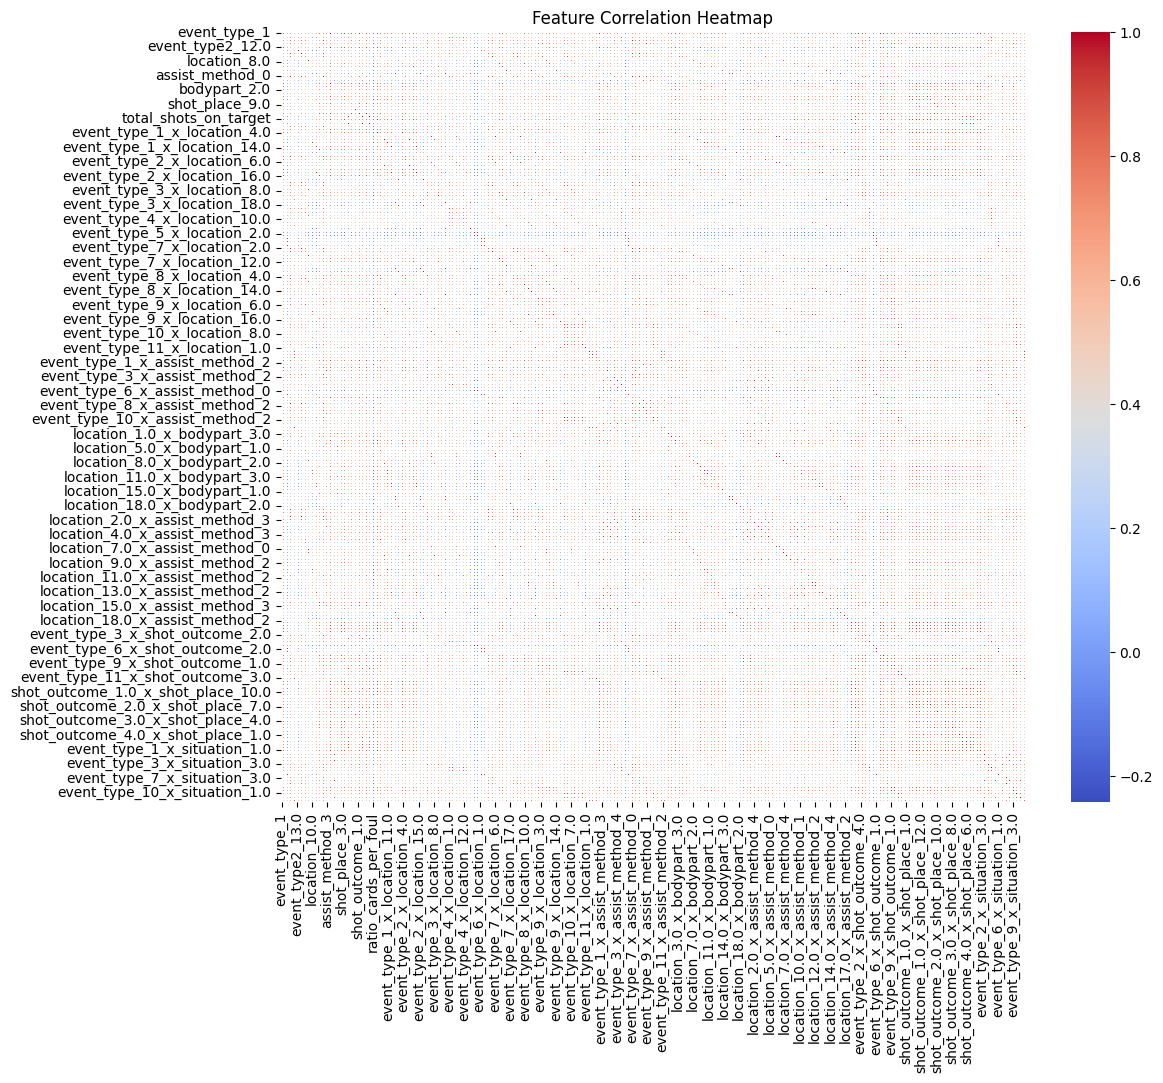

In [251]:
# Plot the correlation heatmap for visual analysis
plt.figure(figsize=(12, 10))
sns.heatmap(correlation_matrix, cmap='coolwarm', linewidths=0.5)
plt.title("Feature Correlation Heatmap")
plt.show()

In [252]:
# Step 2: Convert correlation matrix to distance matrix (1 - abs(correlation))
distance_matrix = 1 - abs(correlation_matrix)

In [253]:
# Step 3: Perform hierarchical clustering on the distance matrix
# Linkage method can be 'single', 'complete', 'average', etc.
linkage_matrix = linkage(squareform(distance_matrix), method='average')

In [254]:
# Step 4: Form clusters based on the correlation threshold
cluster_labels = fcluster(linkage_matrix, t=1 - correlation_threshold, criterion='distance')


In [255]:
# Step 5: Group features into clusters
clusters = {}
for feature, cluster in zip(correlation_matrix.columns, cluster_labels):
    clusters.setdefault(cluster, []).append(feature)

In [256]:
# Step 6: Retain one representative feature per cluster
# Retain the feature with the highest variance within each cluster
features_to_keep = []
for cluster, features in clusters.items():
    if len(features) > 1:
        # Retain the feature with the highest variance
        variances = team_aggregated[features].var()
        best_feature = variances.idxmax()
        features_to_keep.append(best_feature)
    else:
        # If only one feature in the cluster, retain it
        features_to_keep.append(features[0])

In [257]:
# Step 7: Drop all other features not in `features_to_keep`
features_to_drop = [col for col in team_aggregated.columns if col not in features_to_keep and col != 'event_team']
print(f"Features retained after clustering: {len(features_to_keep)} (from {len(correlation_matrix.columns)})")
print(f"Features dropped: {len(features_to_drop)}")
team_aggregated = team_aggregated[['event_team'] + features_to_keep]

Features retained after clustering: 161 (from 537)
Features dropped: 376


In [258]:
# StandardScaler for feature scaling
scaler = StandardScaler()
features_to_scale = [col for col in team_aggregated.columns if col != 'event_team']
scaled_features = scaler.fit_transform(team_aggregated[features_to_scale])

In [259]:
# Create final scaled DataFrame
final_team_cluster_data = pd.DataFrame(scaled_features, columns=features_to_scale)
final_team_cluster_data['event_team'] = team_aggregated['event_team']

In [260]:
# Step 12: Save processed data for clustering
output_file = 'data/final_team_cluster_data2.csv'
final_team_cluster_data.to_csv(output_file, index=False)
print(f"Processed and normalized dataset saved to {output_file}")

Processed and normalized dataset saved to data/final_team_cluster_data2.csv


In [261]:
final_team_cluster_data.columns

Index(['event_type_1_x_situation_1.0', 'event_type_2_x_location_15.0',
       'event_type_3_x_assist_method_0', 'event_type_4_x_assist_method_0',
       'event_type_6_x_assist_method_0', 'event_type_8_x_assist_method_0',
       'event_type_9_x_assist_method_0', 'event_type_10_x_assist_method_0',
       'event_type_11_x_assist_method_0', 'event_type2_14.0',
       ...
       'shot_outcome_4.0_x_shot_place_13.0', 'event_type_1_x_situation_2.0',
       'event_type_8_x_situation_3.0', 'event_type_4_x_situation_2.0',
       'event_type_4_x_situation_4.0', 'event_type_9_x_situation_2.0',
       'event_type_10_x_situation_2.0', 'event_type_10_x_situation_4.0',
       'event_type_11_x_situation_2.0', 'event_team'],
      dtype='object', length=162)